In [1]:
import matplotlib.pyplot as plt 
from glob import glob
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization

import tensorflow.keras.utils as np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
#import tensorflow_addons as tfa
from keras.models import Model

from matplotlib.colors import ListedColormap
#from keras.utils.training_utils import multi_gpu_model


from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import os
import pandas as pd


import pickle
from joblib import dump, load

2023-08-07 13:20:43.553432: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-07 13:20:43.593559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1.GPU 메모리 자동 증가 설정

In [2]:
# GPU 메모리 자동 증가 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# 2.Loading data

In [3]:
%%time
grids=1000
base='/tf/'
data = np.load(base+str(grids)+'data.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

CPU times: user 3.09 s, sys: 2.42 s, total: 5.5 s
Wall time: 5.5 s


# 3.Reshaping & Normalization

In [4]:
%%time
#num_pixels = X_train.shape[1] * X_train.shape[2]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0],grids,grids,1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0],grids,grids,1)).astype('float32')
X_val = X_val.reshape((X_val.shape[0],grids,grids,1)).astype('float32')
print(X_train.shape)
#Normalization                          
maxvalue=X_train[X_train>0].max()

X_train = X_train / maxvalue
X_train[np.isnan(X_train)==True]=0
X_train[np.isinf(X_train)==True]=0

X_test = X_test / maxvalue
X_test[np.isnan(X_test)==True]=0
X_test[np.isinf(X_test)==True]=0

X_val = X_val / maxvalue
X_val[np.isnan(X_val)==True]=0
X_val[np.isinf(X_val)==True]=0

(252, 1000, 1000)
(252, 1000, 1000, 1)
CPU times: user 1.63 s, sys: 1.01 s, total: 2.64 s
Wall time: 2.63 s


# add) Masking SB <26 (brighter) or >=26 (darker)

X_test[X_test<26]=0

# 4. one-hot encoding outputs

In [5]:
%%time
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)
num_classes = y_test.shape[1]

CPU times: user 375 µs, sys: 0 ns, total: 375 µs
Wall time: 267 µs


# 5. Model building

In [6]:
strategy = tf.distribute.MirroredStrategy()
Droprate=0.2
def baseline_model():
# create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(grids,grids, 1),strides=(1, 1), activation='relu',padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(64, (3, 3), activation='relu',strides=(1, 1),padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))


    model.compile(loss=tf.keras.losses.CategoricalFocalCrossentropy(), optimizer='adam', metrics=['accuracy'])    

    return model

# build the model
with strategy.scope():
    model=baseline_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-08-07 13:20:57.756357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46686 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6
2023-08-07 13:20:57.756927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46686 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:b1:00.0, compute capability: 8.6


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1000, 1000, 32)    832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 500, 500, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 500, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 500, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 250, 250, 64)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 250, 250, 64)      0

# Fitting Model

In [8]:
#start_time = tf.timestamp()

# Fit the model
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=2)
# Final evaluation of the model

save_dir = "/tf/Results/models/%i/Log/CNN/"%grids
model_name = '%i_CV2_32_5_64_3_FL'%(grids)#_Drop_0.2
model_path = os.path.join(save_dir, model_name+'.h5')
model.save(model_path)
print('\n Saved trained model at %s ' % model_path)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))



# 실행 시간 계산
#end_time = tf.timestamp()
#execution_time = end_time - start_time
#print("Execution time: ", execution_time.numpy(), " seconds")

# history 객체를 저장
dump(history.history, '/tf/Results/histories/%i/Log/CNN/'%grids+model_name+'.joblib')

Epoch 1/20
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/rep

2023-08-07 13:21:03.354190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-07 13:21:05.964193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-07 13:21:06.883021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-07 13:21:07.806415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-07 13:21:12.758613: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fed84551220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-07 13:21:12.758654: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A600

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
8/8 - 20s - loss: 1.1684 - accuracy: 0.6190 - val_loss: 1.3222 - val_accuracy: 0.6719 - 20s/epoch - 2s/step
Epoch 2/20
8/8 - 4s - loss: 1.3112 - accuracy: 0.6746 - val_loss: 1.3222 - val_accuracy: 0.6719 - 4s/epoch - 470ms/step
Epoch 3/20
8/8 - 4s - loss: 1.3112 - accuracy: 0.6746 - val_loss: 1.3222 - val_accuracy: 0.6719 - 4s/epoch - 529ms/step
Epoch 4/20
8/8 - 4s - loss: 1.3112 - accuracy: 0.6746 - val_loss: 1.3222 - val_accuracy: 0.6719 - 4s/epoch - 499ms/step
Epoch 5/20
8/8 - 4s - loss: 1.3112 - accuracy: 0.6746 - val_loss: 1.3222 - val_accuracy: 0.6719 - 4s/epoch - 543ms/step
Epoch 6/20
8/8 - 4s - loss: 1.3112 - accuracy: 0.6746 - val_loss: 1.3222 - val_accuracy: 0.6719 - 4s/epoch - 553ms/step
Epoch 7/20
8

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



 Saved trained model at /tf/Results/models/1000/Log/CNN/1000_CV2_32_5_64_3_FL.h5 
Baseline Error: 32.50%


['/tf/Results/histories/1000/Log/CNN/1000_CV2_32_5_64_3_FL.joblib']

# Confusion Matrix

In [14]:
y_pred=model.predict(X_test)
confM=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
class_totals = np.sum(confM, axis=1)
cm_norm = confM / class_totals[:, np.newaxis]
np.savez('/tf/Results/confusion/'+str(grids)+'/Log/CNN/'+model_name+'.npz', confusion=confM)

3/3 [==============================] - 0s 60ms/step


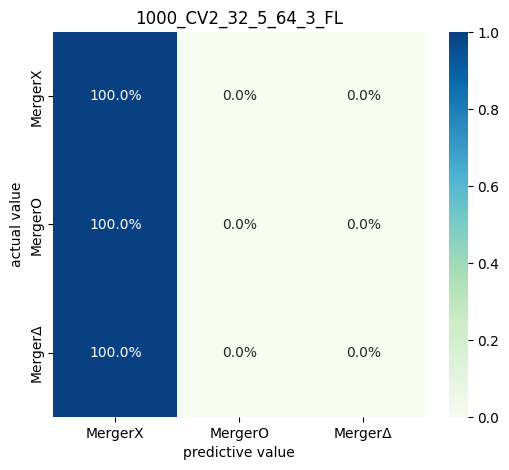

In [15]:
labels=['MergerX','MergerO','MergerΔ']
#print(data)
# Drawing confusion matrix with seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm,annot=True,fmt=".1%",cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')
plt.ylabel('actual value')

plt.title(model_name)
plt.show() 

In [18]:
report=classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),output_dict=True)

df=pd.DataFrame(report).transpose()
df.to_hdf('/tf/Results/confusion/'+str(grids)+'/Log/CNN/'+model_name+'.h5',key='Galaxy',mode='w')   
df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.675000,1.000000,0.805970,54.000
1,0.000000,0.000000,0.000000,21.000
2,0.000000,0.000000,0.000000,5.000
accuracy,0.675000,0.675000,0.675000,0.675
macro avg,0.225000,0.333333,0.268657,80.000
weighted avg,0.455625,0.675000,0.544030,80.000


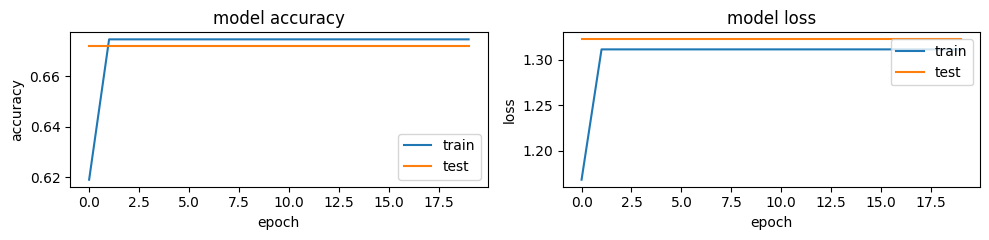

In [17]:
# plotting the metrics
fig = plt.figure(figsize=(10,2.5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.show()

# 7. Drawing Filters and Feature maps

## 7-1) summary of model

In [11]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name: continue
    # summarize output shape
    #print(i, layer.name, layer.output.shape)
    filters, biases = layer.get_weights()
    print(i,layer.name, filters.shape)

0 conv2d (5, 5, 1, 32)
3 conv2d_1 (3, 3, 32, 64)


## 7-2) Drawing trained filters

In [ ]:
# 필터를 이미지로 변환하여 시각화합니다.
filters1, biases1 = model.layers[0].get_weights()
fig=plt.figure(figsize=(12, 12))
print(filters1.shape)
for i in range(filters1.shape[3]):
    ax=plt.subplot(8, 4, i + 1)
    plt.imshow(filters1[:, :, 0, i], cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
filters2, biases2 = model.layers[3].get_weights()
plt.figure(figsize=(15, 5))
for i in range(filters2.shape[3]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters2[:, :, 0, i], cmap='gray')
    plt.axis('off')
    
plt.show()
plt.figure(figsize=(15, 5))
for i in range(filters2.shape[3]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters2[:, :, 1, i], cmap='gray')
    plt.axis('off')
plt.show()

## 7-3) Drawing feature_maps

In [12]:
outlay=[model.layers[i].output for i in [0,3]]
outputs1=Model(inputs=model.inputs,outputs=outlay)

In [13]:
test=np.expand_dims(X_test[1], axis=0)
print(y_test[1])
feature_maps=outputs1.predict(test)

[1. 0. 0.]
1/1 [==============================] - 0s 119ms/step


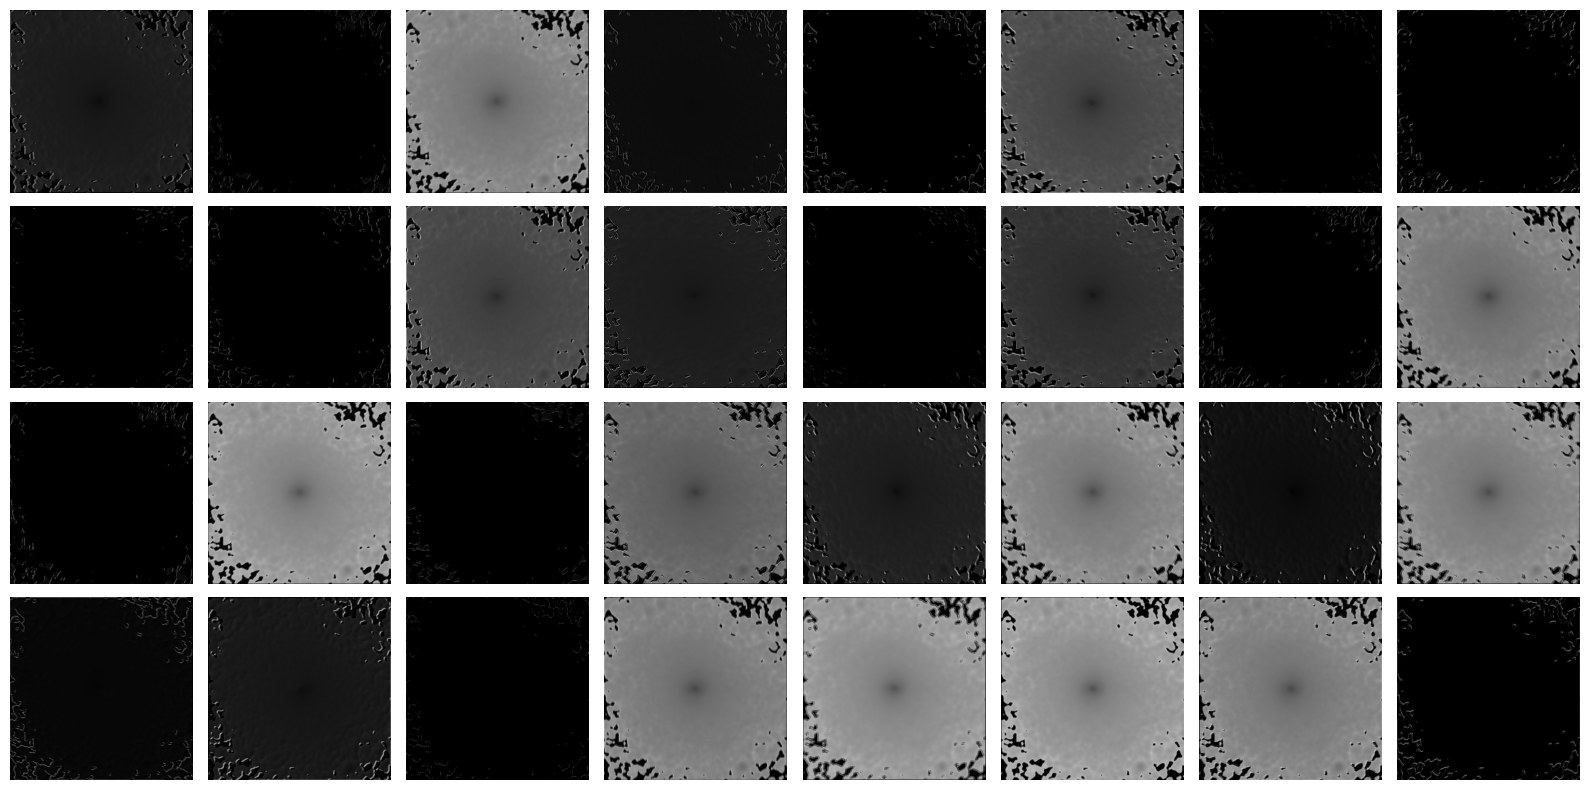

In [14]:
fig=plt.figure(figsize=(16,8))
for i in range(32):
    ax=plt.subplot(4,8,i+1)
    plt.imshow(feature_maps[0][0,:,:,i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

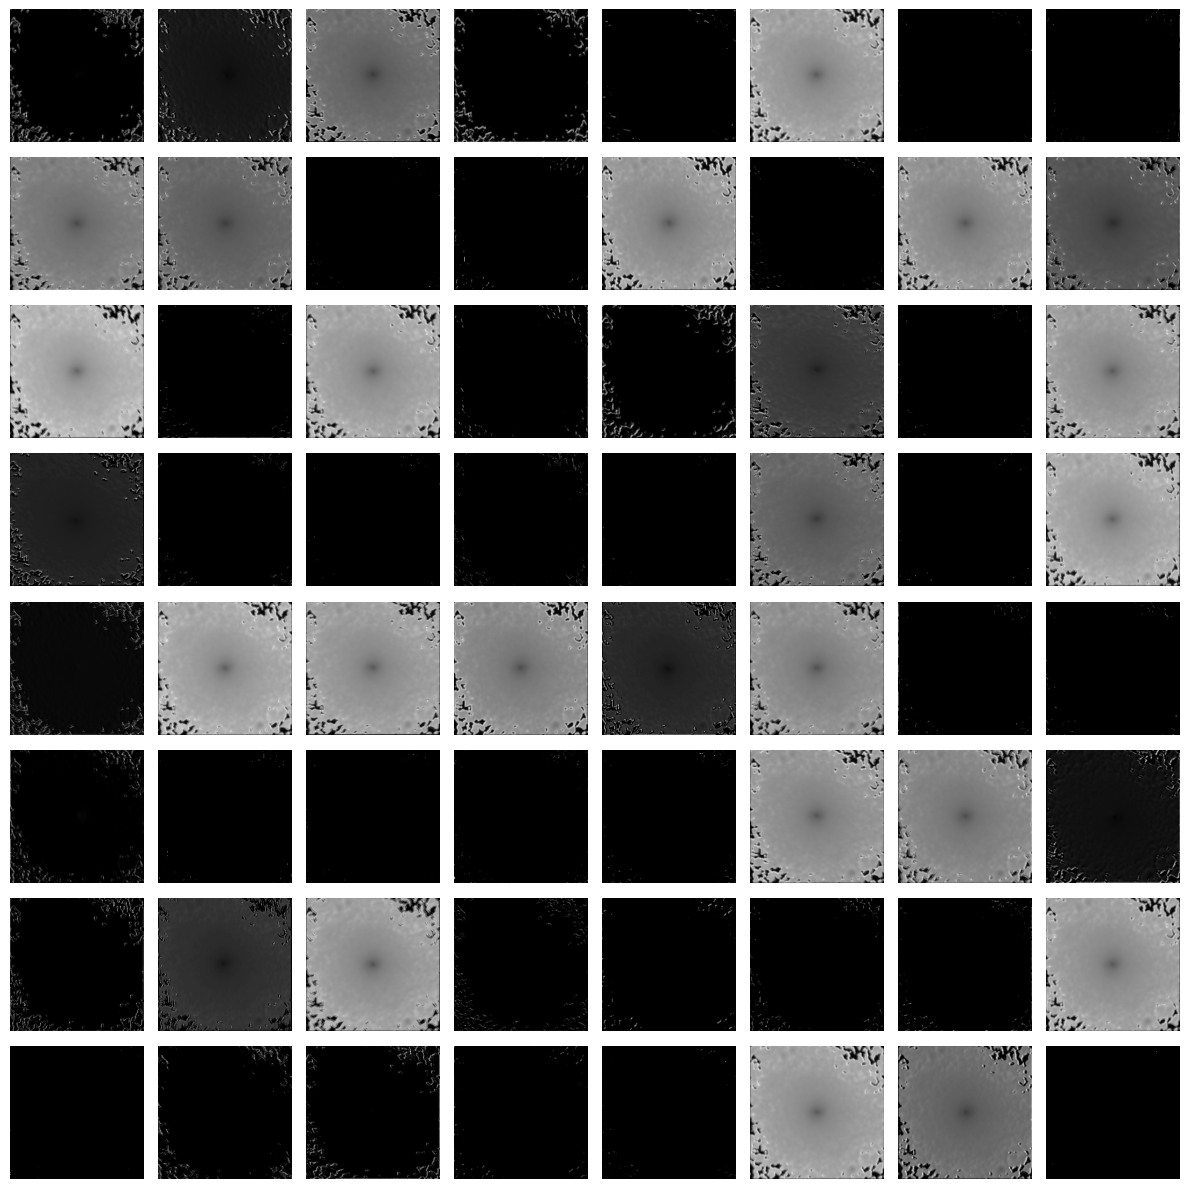

In [15]:
fig=plt.figure(figsize=(12,12))
for i in range(64):
    ax=plt.subplot(8,8,i+1)
    plt.imshow(feature_maps[1][0, :, :, i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

# 8. Drawing Hisotries(loss,accuracy) of the models

In [20]:
history.history['val_loss']

[1.3221871852874756,
 1.3221871852874756,
 1.3221871852874756,
 1.3221871852874756,
 2.469132661819458,
 3.7776777744293213,
 3.7776777744293213,
 3.7776777744293213,
 3.7776777744293213,
 3.7776777744293213,
 3.7776777744293213,
 3.7776777744293213,
 3.7776777744293213,
 3.7776777744293213,
 1.699962854385376,
 1.436514139175415,
 1.3946540355682373,
 1.5740323066711426,
 1.7629163265228271,
 1.7629163265228271]